In [1]:
using GaussianFilters

using LinearAlgebra
using Distributions
using Random

Random.seed!(2019);

In this example, we model motion of a nonholonomic robot with position and heading states, with control over its velocity and angular acceleration. Perfect equations of motion are as follows:

$p^x_{t+1} = p^x_t + \delta t v_t \cos\theta_t$

$p^y_{t+1} = p^y_t + \delta t v_t \sin\theta_t$

$\theta_{t+1} = \theta_t + \delta t \phi_t$

Measurements come in the form of noisy range measurements from $(0,0)$. Perfect measurement equations:

$y_t = \lVert p_t \rVert = \sqrt{(p^x_t)^2+(p^y_t)^2}$

In [2]:
# nonlinear dynamics function. must be a function of both states (x) and actions (u) even if either are not used.
dt=0.1
function step(x,u)
    v,ϕ = u
    xp = x
    xp += dt*([v*cos(x[3]);v*sin(x[3]); ϕ])
    xp[3] = xp[3]
    return xp
end  

W = dt*0.05*Matrix{Float64}(I,3,3)

# build dynamics model
dmodel = NonlinearDynamicsModel(step,W);

In [3]:
# nonlinear observation function. must be a function of both states (x) and actions (u) even if either are not used.
function observe(x,u)
    y = [norm(x[1:2])]
end

V = 0.1*Matrix{Float64}(I,1,1)

# build observation model
omodel = NonlinearObservationModel(observe,V)

# build ukf
ukf = UnscentedKalmanFilter(dmodel,omodel);

Initialize belief, generate action sequence (in this case, constant velocity with circulating angular rate), simulate model.

In [4]:
times = 0:dt:40
action_sequence = [[1.0, 2*sin(pi/2*t)] for t in times]

b0 = GaussianBelief([0.0,0.0,0.0], 0.01*Matrix{Float64}(I,3,3))

sim_states, sim_measurements = simulation(ukf,b0,action_sequence);

Run filter on simulated data

In [5]:
filtered_beliefs = run_filter(ukf, b0, action_sequence, sim_measurements)

# turn array of belief structs into simple tensors.
μ, Σ = unpack(filtered_beliefs); 

### Plot

In [6]:
using Plots

Truth:

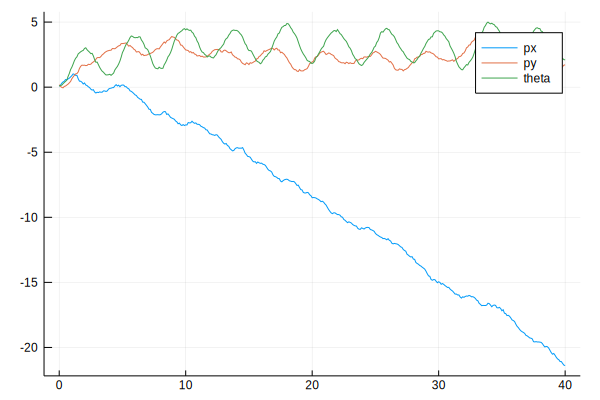

In [7]:
plot(times,hcat(sim_states[2:end]...)',labels=["px","py","theta"])

With State Estimates:

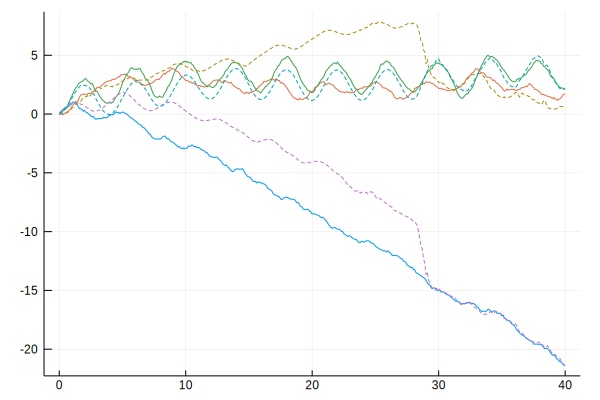

In [8]:
plot!(times,μ[2:end,:], linestyle=:dash)
plot!(legend=false)

Comparison with EKF

In general, UKF is more appropriate when the problem is highly non-linear or high-dimensional.

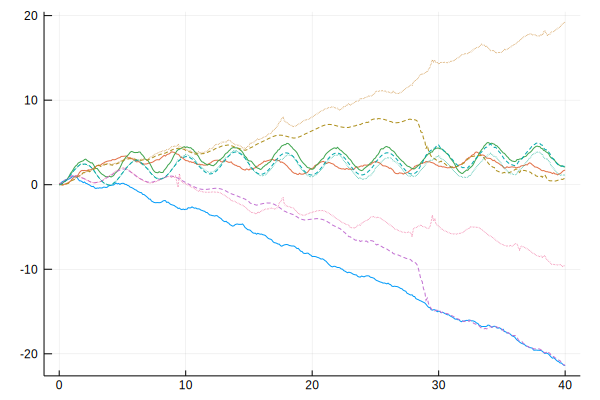

In [9]:
# form and run ekf
ekf = ExtendedKalmanFilter(dmodel,omodel);
filtered_beliefs_ekf = run_filter(ekf, b0, action_sequence, sim_measurements)

# turn array of belief structs into simple tensors.
μ_ekf, Σ_ekf = unpack(filtered_beliefs_ekf); 

plot!(times,μ_ekf[2:end,:], linestyle=:dot)
plot!(legend=false)